# Background Estimation (photutils.background)

Documentation at the following link:

https://photutils.readthedocs.io/en/stable/background.html

# Introduction

To accurately measure the photometry and morphological properties of astronomical sources, one requires an accurate estimate of the background, which can be from both the sky and the detector. Similarly, having an accurate estimate of the background noise is important for determining the significance of source detections and for estimating photometric errors.

# Simple Statistics

If the background level and noise are relatively constant across an image, the simplest way to estimate these values is to derive scalar quantities using simple approximations. Of course, when computing the image statistics one must take into account the astronomical sources present in the images, which add a positive tail to the distribution of pixel intensities.

As an example, we load a synthetic image comprised of 100 sources with a Gaussian-distributed background whose mean is 5 and standard deviation is 2:

In [7]:
from photutils.datasets import make_100gaussians_image
data = make_100gaussians_image()

**Note**: the following link give access to load a few example datasets:

https://photutils.readthedocs.io/en/stable/datasets.html

In [8]:
%matplotlib inline
from matplotlib import style, pyplot as plt

plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['axes.prop_cycle'] = style.library['seaborn-deep']['axes.prop_cycle']
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['axes.titlesize'] =  plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] =  plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['image.interpolation'] = 'nearest'

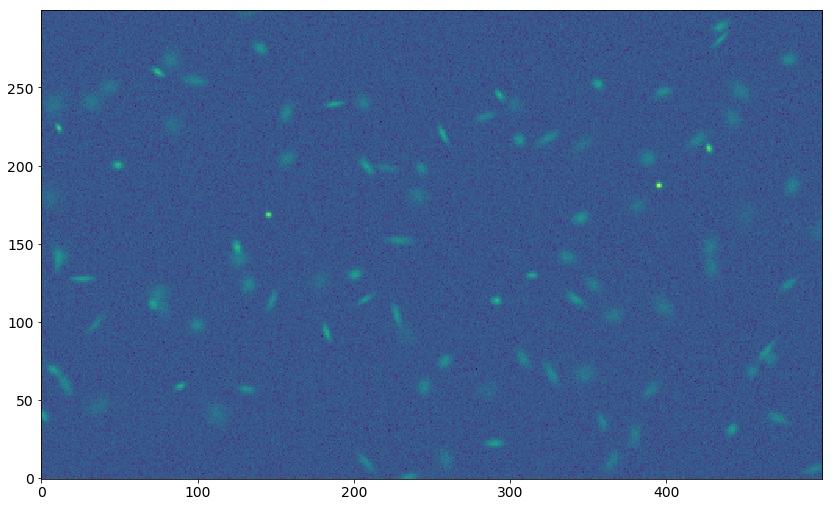

In [9]:
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(data, norm=norm)

The image median and biweight location are both larger than the true background level of 5:

In [7]:
import numpy as np
from astropy.stats import biweight_location
print(np.median(data))  
print(biweight_location(data))  

5.225529518399048
5.186759755495727


Similarly, using the median absolute deviation to estimate the background noise level gives a value that is larger than the true value of 2:

In [8]:
from astropy.stats import mad_std
print(mad_std(data))

2.144376009659891


# Sigma Clipping Sources

The most widely used technique to remove the sources from the image statistics is called sigma clipping. Briefly, pixels that are above or below a specified sigma level from the median are discarded and the statistics are recalculated. The procedure is typically repeated over a number of iterations or until convergence is reached. This method provides a better estimate of the background and background noise levels:

In [9]:
from astropy.stats import sigma_clipped_stats
mean, median, std = sigma_clipped_stats(data, sigma=3.0)
print((mean, median, std))  

(5.199138651621793, 5.155587433358291, 2.094275212132969)


# Masking Sources

An even better procedure is to exclude the sources in the image by masking them. Of course, this technique requires one to identify the sources in the data, which in turn depends on the background and background noise. Therefore, this method for estimating the background and background RMS requires an iterative procedure.

Photutils provides a convenience function, $\color{blue}{\text{make_source_mask()}}$, for creating source masks. It uses sigma-clipped statistics as the first estimate of the background and noise levels for the source detection. Sources are then identified using image segmentation. Finally, the source masks are dilated to mask more extended regions around the detected sources.

Documentation for $\color{blue}{\text{make_source_mask()}}$:

https://photutils.readthedocs.io/en/stable/api/photutils.make_source_mask.html

Here we use an aggressive 2-sigma detection threshold to maximize the source detections and dilate using a 11x11 box:

In [10]:
from photutils import make_source_mask
mask = make_source_mask(data, snr=2, npixels=5, dilate_size=11)
mean, median, std = sigma_clipped_stats(data, sigma=3.0, mask=mask)
print((mean, median, std))

(5.001013475475569, 5.000584905604376, 1.970887100626572)


# 2D Background and Noise Estimation

If the background or the background noise varies across the image, then you will generally want to generate a 2D image of the background and background RMS (or compute these values locally). This can be accomplished by applying the above techniques to subregions of the image.

Photutils provides the $\color{blue}{\text{Background2D}}$ class to estimate the 2D background and background noise in an astronomical image. Background2D requires the size of the box `box_size` in which to estimate the background.

The background level in each of the meshes is calculated using the function or callable object (e.g. class instance) input via `bkg_estimator` keyword. Photutils provides a several background classes that can be used:

- $\color{blue}{\text{MeanBackground}}$
- $\color{blue}{\text{MedianBackground}}$
- $\color{blue}{\text{ModeEstimatorBackground}}$
- $\color{blue}{\text{MMMBackground}}$
- $\color{blue}{\text{SExtractorBackground}}$
- $\color{blue}{\text{BiweightLocationBackground}}$

The default is a $\color{blue}{\text{SExtractorBackground}}$ instance. For this method, the background in each mesh is calculated as `2.5 * median) - (1.5 * mean)`. However, if `(mean - median) / std > 0.3` then the `median` is used instead (despite what the SExtractor User’s Manual says, this is the method it always uses).

Likewise, the background RMS level in each mesh is calculated using the function or callable object input via the `bkgrms_estimator` keyword. Photutils provides the following classes for this purpose:

- $\color{blue}{\text{StdBackgroundRMS}}$
- $\color{blue}{\text{MADStdBackgroundRMS}}$
- $\color{blue}{\text{BiweightScaleBackgroundRMS}}$

Documentation for $\color{blue}{\text{Background2D}}$

https://photutils.readthedocs.io/en/stable/api/photutils.background.Background2D.html#photutils.background.Background2D

For this example, we will create a test image by adding a strong background gradient to the image defined above:

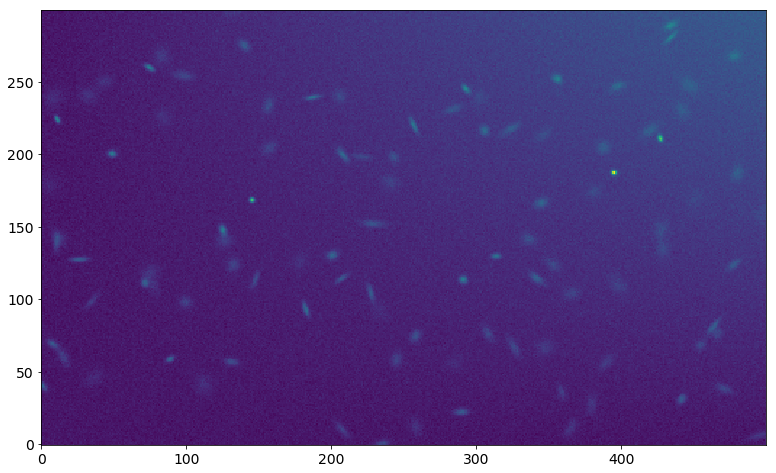

In [22]:
ny, nx = data.shape
y, x = np.mgrid[:ny, :nx]
gradient =  x * y / 5000.
data2 = data + gradient
plt.imshow(data2)

We start by creating a $\color{blue}{\text{Background2D}}$ object using a box size of 50x50 and a 3x3 median filter. We will estimate the background level in each mesh as the sigma-clipped median using an instance of $\color{blue}{\text{MedianBackground}}$.

In [12]:
from astropy.stats import SigmaClip
from photutils import Background2D, MedianBackground
sigma_clip = SigmaClip(sigma=3.)
bkg_estimator = MedianBackground()
bkg = Background2D(data2, (50, 50), filter_size=(3, 3),
                   sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

The 2D background and background RMS images are retrieved using the `background` and `background_rms` attributes, respectively, on the returned object. The low-resolution versions of these images are stored in the `background_mesh` and `background_rms_mesh` attributes, respectively. The global median value of the low-resolution background and background RMS image can be accessed with the `background_median` and `background_rms_median` attributes, respectively:

In [13]:
print(bkg.background_median)  
print(bkg.background_rms_median)  

10.821997862561792
2.298820539683762


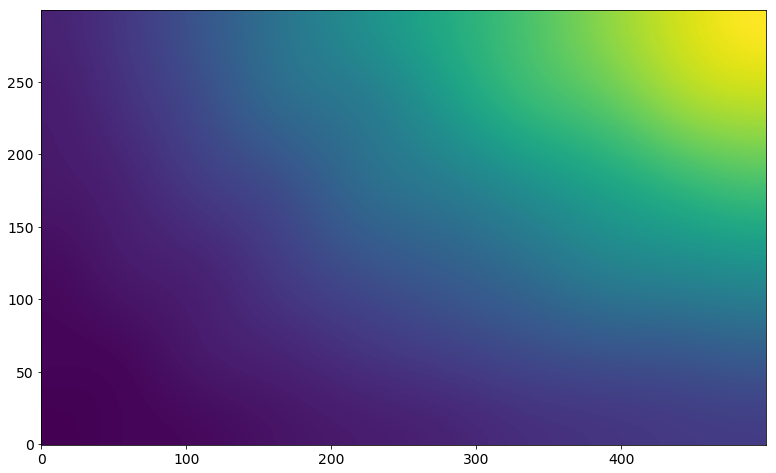

In [23]:
plt.imshow(bkg.background)

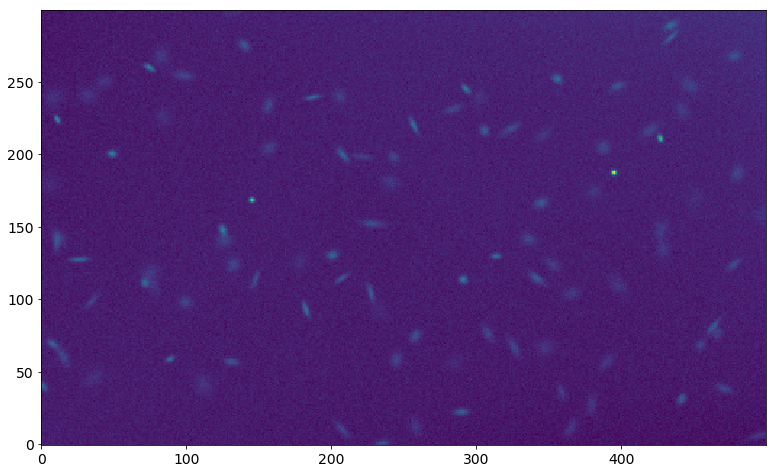

In [24]:
plt.imshow(data2 - bkg.background)

# Masking

Masks can also be input into $\color{blue}{\text{Background2D}}$. As described above, this can be employed to mask sources in the image prior to estimating the background levels.

Additionally, input masks are often necessary if your data array includes regions without data coverage (e.g., from a rotated image or an image from a mosaic). Otherwise the data values in the regions without coverage (usually zeros or NaNs) will adversely contribute to the background statistics.

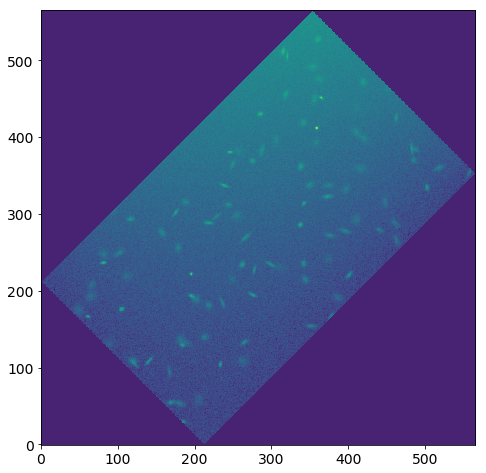

In [25]:
from scipy.ndimage import rotate
data3 = rotate(data2, -45.)
norm = ImageNormalize(stretch=SqrtStretch())  
plt.imshow(data3, norm=norm)  

Now we create a coverage mask and input it into Background2D to exclude the regions where we have no data. For real data, one can usually create a coverage mask from a weight or noise image. In this example we also use a smaller box size to help capture the strong gradient in the background:

In [26]:
mask = (data3 == 0)
bkg3 = Background2D(data3, (25, 25), filter_size=(3, 3), mask=mask)

The input masks are never applied to the returned background image because the input mask can represent either a coverage mask or a source mask, or a combination of both. Therefore, we need to manually apply the coverage mask to the returned background image:

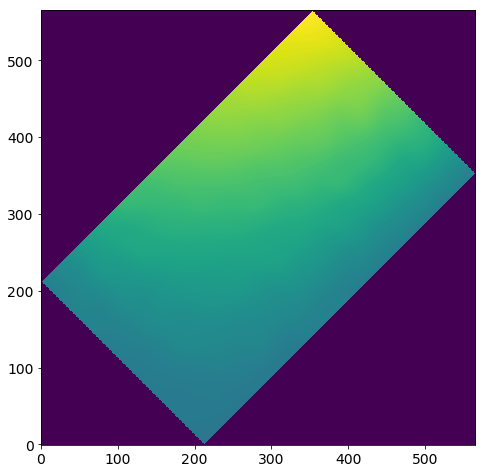

In [27]:
back3 = bkg3.background * ~mask
norm = ImageNormalize(stretch=SqrtStretch())  
plt.imshow(back3, norm=norm)  

Finally, let’s subtract the background from the image and plot it:

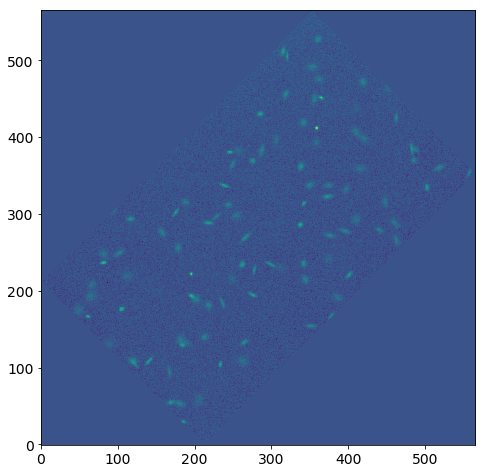

In [28]:
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(data3 - back3, norm=norm)

# Plotting Meshes

Finally, the meshes that were used in generating the 2D background can be plotted on the original image using the $\bf\text{plot_meshes}$ method:

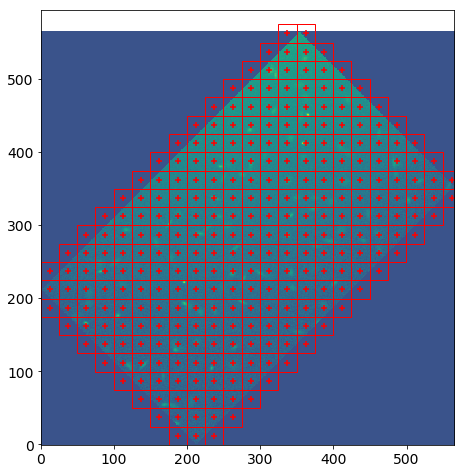

In [30]:
plt.imshow(data3, norm=norm)
bkg3.plot_meshes(outlines=True, color='r')